In [21]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F

import io
import roma
import kornia
import evo
import evo.main_ape as main_ape
import evo.main_rpe as main_rpe
import utils.colmap as colmap_utils


from tqdm import tqdm
from evo.core.metrics import PoseRelation, Unit
from evo.core.trajectory import PoseTrajectory3D
from evo.core import lie_algebra
from evo.tools.plot import PlotMode
from copy import deepcopy
from scipy.spatial.transform import Rotation
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio, load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map
from vggt.utils.helper import create_pixel_coordinate_grid, randomly_limit_trues
from vggt.dependency.track_predict import predict_tracks
from vggt.dependency.np_to_pycolmap import batch_np_matrix_to_pycolmap, batch_np_matrix_to_pycolmap_wo_track

from utils.umeyama import umeyama
from utils.metric_torch import camera_to_rel_deg, calculate_auc_np

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [2]:
def run_VGGT(model, images, dtype, resolution=518, track_feat=False):
    # images: [B, 3, H, W]

    assert len(images.shape) == 4
    assert images.shape[1] == 3

    device = next(model.parameters()).device
    images = images.to(device)
    
    with torch.no_grad():
        with torch.cuda.amp.autocast(dtype=dtype):
            images = images[None]  # add batch dimension
            valid_layers = model.depth_head.intermediate_layer_idx
            if valid_layers[-1] != model.aggregator.aa_block_num - 1:
                valid_layers.append(model.aggregator.aa_block_num - 1)
            aggregated_tokens_list, ps_idx = model.aggregator(images, valid_layers)
            aggregated_tokens_list = [tokens.to(device) if tokens is not None else None for tokens in aggregated_tokens_list]

        # Predict Cameras
        pose_enc = model.camera_head(aggregated_tokens_list)[-1]
        # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])
        # Predict Depth Maps
        depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = depth_map.squeeze(0).cpu().numpy()
        depth_conf = depth_conf.squeeze(0).cpu().numpy()

        track_feature_maps = None if not track_feat else model.track_head.feature_extractor(aggregated_tokens_list, images, ps_idx)
        
    return extrinsic, intrinsic, depth_map, depth_conf, track_feature_maps

def evaluate_auc(pred_se3, gt_se3, device):

    camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
    camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
    c, R, t = umeyama(camera_centers_gt.T, camera_centers_pred.T)
    camera_centers_gt_aligned = (c * (R @ camera_centers_gt.T) + t).T
    print("    --  Umeyama Scale: ", c)
    print("    --  Umeyama Rotation: \n", R)
    print("    --  Umeyama Translation: \n", t)

    ext_transform = np.eye(4)
    ext_transform[:3, :3] = R
    ext_transform[:3, 3:] = t
    ext_transform = np.linalg.inv(ext_transform)

    gt_aligned = np.zeros((gt_se3.shape[0], 4, 4))
    gt_aligned[:, :3, :3] = gt_se3[:, :3, :3].cpu().numpy()
    gt_aligned[:, :3, 3] = gt_se3[:, 3, :3].cpu().numpy() * c
    gt_aligned[:, 3, 3] = 1.0
    gt_aligned = np.einsum('bmn,bnk->bmk', gt_aligned, ext_transform[None])

    gt_se3_aligned = torch.eye(4, device=device).unsqueeze(0).repeat(len(gt_se3), 1, 1)
    gt_se3_aligned[:, :3, :3] = torch.tensor(gt_aligned[:, :3, :3], device=device)
    gt_se3_aligned[:, 3, :3] = torch.tensor(gt_aligned[:, :3, 3], device=device)

    rel_rangle_deg, rel_tangle_deg = camera_to_rel_deg(pred_se3, gt_se3_aligned, device, 4)
    print(f"    --  Pair Rot   Error (Deg) of Vanilla: {rel_rangle_deg.mean():10.2f}")
    print(f"    --  Pair Trans Error (Deg) of Vanilla: {rel_tangle_deg.mean():10.2f}")

    rError = rel_rangle_deg.cpu().numpy()
    tError = rel_tangle_deg.cpu().numpy()

    Auc_30 = calculate_auc_np(rError, tError, max_threshold=30)
    print(f"    --  AUC at 30: {Auc_30:.4f}")

    results = {
        'rel_rangle_deg': rel_rangle_deg.mean(),
        'rel_tangle_deg': rel_tangle_deg.mean(),
        'Auc_30': Auc_30,
    }

    return results

In [3]:
# Initialize the model and load the pretrained weights.
# This will automatically download the model weights the first time it's run, which may take a while.
model = VGGT.from_pretrained("facebook/VGGT-1B").to(device)
model.eval()

VGGT(
  (aggregator): Aggregator(
    (patch_embed): DinoVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (blocks): ModuleList(
        (0-23): 24 x NestedTensorBlock(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): MemEffAttention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): LayerScale()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (act): GELU(approximate=

In [4]:
# Get image paths and preprocess them
data_dir = "../data/MipNeRF360/bonsai"
sparse_dir_gt = os.path.join(data_dir, "sparse", "0")
dust_dir = os.path.join(data_dir, "mast3r")
images_dir = os.path.join(data_dir, "images")

cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))
# images_gt = dict(sorted(images_gt.items(), key=lambda item: item[0]))

In [5]:
sample_interval = 2
images_gt_updated = {id: images_gt[id] for id in list(images_gt.keys())[::sample_interval]}
image_path_list = [os.path.join(images_dir, images_gt_updated[id].name) for id in images_gt_updated.keys()]
base_image_path_list = [os.path.basename(path) for path in image_path_list]
total_frame_num = len(image_path_list)

vggt_fixed_resolution = 518
images, original_coords = load_and_preprocess_images_ratio(image_path_list, vggt_fixed_resolution)

# plot images
# plt.figure(figsize=(16, 10))
# for i, img in enumerate(images):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(img.permute(1, 2, 0).cpu().numpy())
#     plt.title(base_image_path_list[i].split('_Zenmuse')[0])
#     plt.axis('off')

In [6]:
# Run VGGT to estimate camera and depth
# Run with 518x518 images
extrinsic, intrinsic, depth_map, depth_conf, track_feats = run_VGGT(model, images, dtype, vggt_fixed_resolution, track_feat=True)
points_3d = unproject_depth_map_to_point_map(depth_map, extrinsic, intrinsic)
torch.cuda.empty_cache()

## 1. Calculate Tracking

/tmp/ipykernel_48836/2309486545.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(-0.5, 517.5, 349.5, -0.5)

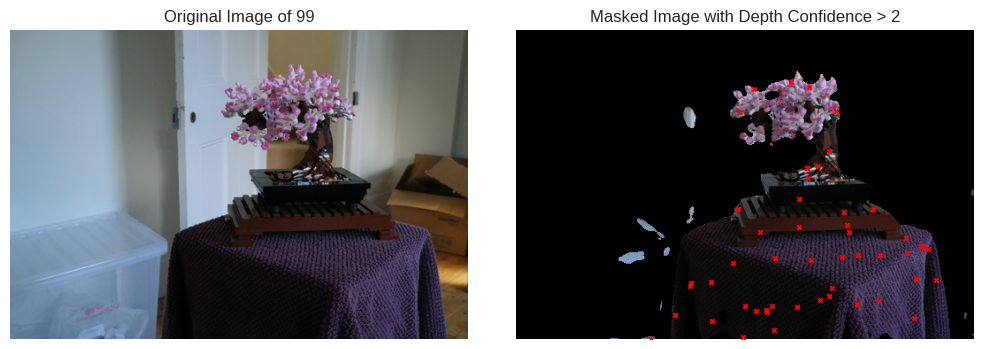

In [10]:
conf_threshold = 2
num_track_pts = 50
mask = depth_conf > conf_threshold

idx = random.randint(0, total_frame_num - 1)
image_masked = images[idx].cpu().numpy().transpose(1, 2, 0) * mask[idx][:, :, None]
image_org = images[idx].cpu().numpy().transpose(1, 2, 0)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_org)
plt.title(f"Original Image of {idx}")
plt.tight_layout()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_masked)
plt.title("Masked Image with Depth Confidence > {}".format(conf_threshold))
# pick up num_track_pts points with highest depth confidence and mark them as red x on the image
# mark_points = np.argsort(depth_conf[idx].flatten())[-num_track_pts:]
# randomly select num_track_pts points with highest depth confidence and mark them as red x on the image
valid_index = np.where(mask[idx].flatten())[0].tolist()
mark_points = random.sample(valid_index, num_track_pts)
for point in mark_points:
    y, x = divmod(point, depth_conf[idx].shape[1])
    plt.scatter(x, y, color='red', s=10, marker='x')

plt.tight_layout()
plt.axis('off')

In [12]:
# Predict Tracks
# choose your own points to track, with shape (N, 2) for one scene
from vggt.utils.visual_track import visualize_tracks_on_images

torch.cuda.empty_cache()

save_dir = f"track_visuals_{os.path.basename(data_dir)}"
# delete the track_visuals directory if it exists
if os.path.exists(save_dir):
    import shutil
    shutil.rmtree(save_dir)

conf_threshold = 2.0
score_threshold = conf_threshold * 0.05
max_num_track_pts = 100
mask = depth_conf > conf_threshold

corr_mask = np.zeros(depth_conf.shape[0], dtype=bool)
rest_frame_idx = np.where(~corr_mask)[0].tolist()

tracks_list = []
vis_scores_list = []
conf_scores_list = []
frame_idx_list = []
tgt_idx_list = []
iteration = 0

while all(corr_mask) is False:

    query_points_list = []
    if len(rest_frame_idx) > 0:
        start_idx = rest_frame_idx.pop(0)
    else:
        break
    valid_index = np.where(mask[start_idx].flatten())[0].tolist()

    if len(valid_index) == 0:
        print(f"No valid points found for frame {start_idx}, skipping...")
        continue

    # num_track_pts = min(max_num_track_pts, len(valid_index))
    num_track_pts = max_num_track_pts
    mark_points = np.random.choice(valid_index, num_track_pts, replace=True).tolist()
    for point in mark_points:
        y, x = divmod(point, depth_conf[start_idx].shape[1])
        query_points_list.append([x, y])

    query_points = torch.FloatTensor(query_points_list).to(device)

    # reorder the image, make the start_idx image the first one
    reordered_idx = list(range(start_idx, total_frame_num)) + list(range(0, start_idx))
    # reordered_idx = [start_idx] + random.sample(reordered_idx[1:], query_frame_num - 1)
    with torch.no_grad():
        print(f"Number of query points: {len(query_points_list)}, start index: {start_idx}, {sum(~corr_mask)} frames are rest")
        track_list, vis_score, conf_score = model.track_head.tracker(query_points=query_points[None], fmaps=track_feats[:, reordered_idx], iters=model.track_head.iters)
        valid_track_score_mask = (conf_score > score_threshold) & (vis_score > score_threshold)
        valid_track_num = valid_track_score_mask.sum(dim=-1)
        valid_track_num_mask = valid_track_num > num_track_pts // 5
        valid_idx = torch.where(valid_track_num_mask[0])[0].tolist()

        if len(valid_idx) <= 1:
            print(f"No valid tracks found for frame {start_idx}, skipping...")
            continue

        tracks_list.append(track_list[-1][0, valid_idx].cpu().numpy())
        vis_scores_list.append(vis_score[0, valid_idx].cpu().numpy())
        conf_scores_list.append(conf_score[0, valid_idx].cpu().numpy())
        tgt_idx_list += [len(frame_idx_list)] * len(valid_idx)
        valid_frame_idx = [reordered_idx[i] for i in valid_idx]
        frame_idx_list += valid_frame_idx
        
    corr_mask[valid_frame_idx] = True
    rest_frame_idx = np.where(~corr_mask)[0].tolist()
    
    visualize_tracks_on_images(images[reordered_idx][valid_idx], track_list[-1][:, valid_idx], valid_track_score_mask[:, valid_idx], out_dir=f"{save_dir}/{iteration:04d}_start_{start_idx:04d}")

print(f"Total {len(frame_idx_list)} correspondence pairs are predicted.")
print(f"Total {sum(~corr_mask)} frames find no correspondence.")
# visualize_tracks_on_images(images, track_list[-1], (conf_score>0.2) & (vis_score>0.2), out_dir="track_visuals")

Number of query points: 100, start index: 0, 146 frames are rest


[INFO] Saved color-by-XY track visualization grid -> track_visuals_bonsai/0000_start_0000/tracks_grid.png
[INFO] Saved 60 individual frames to track_visuals_bonsai/0000_start_0000/frame_*.png
Number of query points: 100, start index: 35, 86 frames are rest
[INFO] Saved color-by-XY track visualization grid -> track_visuals_bonsai/0000_start_0035/tracks_grid.png
[INFO] Saved 30 individual frames to track_visuals_bonsai/0000_start_0035/frame_*.png
Number of query points: 100, start index: 38, 81 frames are rest
[INFO] Saved color-by-XY track visualization grid -> track_visuals_bonsai/0000_start_0038/tracks_grid.png
[INFO] Saved 33 individual frames to track_visuals_bonsai/0000_start_0038/frame_*.png
Number of query points: 100, start index: 41, 79 frames are rest
[INFO] Saved color-by-XY track visualization grid -> track_visuals_bonsai/0000_start_0041/tracks_grid.png
[INFO] Saved 7 individual frames to track_visuals_bonsai/0000_start_0041/frame_*.png
Number of query points: 100, start ind

In [13]:
import kornia
from scipy.ndimage import map_coordinates

image_names = np.array([base_image_path_list[i] for i in frame_idx_list])
tracks = np.concatenate(tracks_list, axis=0)
vis_scores = np.concatenate(vis_scores_list, axis=0)
conf_scores = np.concatenate(conf_scores_list, axis=0)
target_indexes = np.array(tgt_idx_list)
frame_indexes = np.array(frame_idx_list)

frame_indexes = frame_indexes[:, None].repeat(tracks.shape[1], axis=1)
frame_names = image_names[:, None].repeat(tracks.shape[1], axis=1)
valid_track_score_mask = (conf_scores > score_threshold) & (vis_scores > score_threshold)

corr_points_i = tracks[valid_track_score_mask]
corr_points_j = tracks[target_indexes][valid_track_score_mask]

image_names_i = frame_names[valid_track_score_mask]
image_names_j = frame_names[target_indexes][valid_track_score_mask]

frame_indexes_i = frame_indexes[valid_track_score_mask]
frame_indexes_j = frame_indexes[target_indexes][valid_track_score_mask]

vis_scores_i = vis_scores[valid_track_score_mask]
vis_scores_j = vis_scores[target_indexes][valid_track_score_mask]

conf_scores_i = conf_scores[valid_track_score_mask]
conf_scores_j = conf_scores[target_indexes][valid_track_score_mask]

same_pt_mask = (image_names_i == image_names_j)
corr_points_i = corr_points_i[~same_pt_mask]
corr_points_j = corr_points_j[~same_pt_mask]
image_names_i = image_names_i[~same_pt_mask]
image_names_j = image_names_j[~same_pt_mask]
frame_indexes_i = frame_indexes_i[~same_pt_mask]
frame_indexes_j = frame_indexes_j[~same_pt_mask]
vis_scores_i = vis_scores_i[~same_pt_mask]
vis_scores_j = vis_scores_j[~same_pt_mask]
conf_scores_i = conf_scores_i[~same_pt_mask]
conf_scores_j = conf_scores_j[~same_pt_mask]

# depths_i = depth_map[frame_indexes_i, np.around(corr_points_i[:, 1]).astype(int), np.around(corr_points_i[:, 0]).astype(int)]
# depths_j = depth_map[frame_indexes_j, np.around(corr_points_j[:, 1]).astype(int), np.around(corr_points_j[:, 0]).astype(int)]
# corr_points_i = np.concatenate([corr_points_i, depths_i], axis=1)
# corr_points_j = np.concatenate([corr_points_j, depths_j], axis=1)

intrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
intrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
intrinsic_i[:, :3, :3] = intrinsic[frame_indexes_i]
intrinsic_j[:, :3, :3] = intrinsic[frame_indexes_j]
intrinsic_i[:, 3, 3] = 1.0
intrinsic_j[:, 3, 3] = 1.0

extrinsic_i = np.zeros((corr_points_i.shape[0], 4, 4), dtype=np.float32)
extrinsic_j = np.zeros((corr_points_j.shape[0], 4, 4), dtype=np.float32)
extrinsic_i[:, :3, :4] = extrinsic[frame_indexes_i]
extrinsic_j[:, :3, :4] = extrinsic[frame_indexes_j]
extrinsic_i[:, 3, 3] = 1.0
extrinsic_j[:, 3, 3] = 1.0

corr_points_i_tensor = torch.FloatTensor(corr_points_i).to(device)
corr_points_j_tensor = torch.FloatTensor(corr_points_j).to(device)
weight_i = torch.FloatTensor(vis_scores_i * conf_scores_i).to(device)
weight_j = torch.FloatTensor(vis_scores_j * conf_scores_j).to(device)
intrinsic_i_tensor = torch.FloatTensor(intrinsic_i).to(device)
intrinsic_j_tensor = torch.FloatTensor(intrinsic_j).to(device)
extrinsic_i_tensor = torch.FloatTensor(extrinsic_i).to(device)
extrinsic_j_tensor = torch.FloatTensor(extrinsic_j).to(device)

with torch.no_grad():
    P_i = intrinsic_i_tensor @ extrinsic_i_tensor
    P_j = intrinsic_j_tensor @ extrinsic_j_tensor
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i_tensor[:, None, :2], corr_points_j_tensor[:, None, :2], Fm, squared=False, eps=1e-08)
    weight = torch.sqrt(weight_i * weight_j)
    err = err * weight[:, None] / weight.mean()

# show the error distribution
plt.figure(figsize=(10, 5))
plt.hist(err.cpu().numpy(), bins=100, density=True)
plt.title(f"Symmetrical Epipolar Distance Distribution of {len(err)} correspondences, average: {err.mean().item():.3f}, std: {err.std().item():.3f}")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

sampled_i = torch.zeros((corr_points_i_tensor.shape[0], 3), dtype=images.dtype, device=images.device)
sampled_j = torch.zeros((corr_points_j_tensor.shape[0], 3), dtype=images.dtype, device=images.device)

with torch.no_grad():
    corr_points_i_normalized = corr_points_i_tensor.to(images.device) / original_coords[frame_indexes_i][:, 2:4] * 2 - 1
    corr_points_j_normalized = corr_points_j_tensor.to(images.device) / original_coords[frame_indexes_j][:, 2:4] * 2 - 1

    for frame_idx in tqdm(np.unique(frame_indexes_i)):
        sampled_i[frame_indexes_i==frame_idx] = F.grid_sample(
            images[frame_idx].unsqueeze(0),
            corr_points_i_normalized[frame_indexes_i==frame_idx][None, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze().permute(1, 0)

    for frame_idx in tqdm(np.unique(frame_indexes_j)):
        sampled_j[frame_indexes_j==frame_idx] = F.grid_sample(
            images[frame_idx].unsqueeze(0),
            corr_points_j_normalized[frame_indexes_j==frame_idx][None, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze().permute(1, 0)

    err_rgb = torch.norm(sampled_i - sampled_j, dim=-1)
    
# show the error distribution
plt.figure(figsize=(10, 5))
plt.hist(err_rgb.cpu().numpy(), bins=100, density=True)
plt.title(f"RGB Distance Distribution of {len(err_rgb)} correspondences, average: {err_rgb.mean().item():.3f}, std: {err_rgb.std().item():.3f}")
plt.xlabel("Distance")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

/tmp/ipykernel_48836/4217422341.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
100%|██████████| 26/26 [00:00<00:00, 2400.97it/s]
/tmp/ipykernel_48836/4217422341.py:118: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [14]:
save_dir = os.path.join(os.path.dirname(data_dir)+'_vggt', os.path.basename(data_dir))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

np.save(os.path.join(save_dir, f'corr.npy'), {
    'corr_points_i_normalized': corr_points_i_normalized.cpu().numpy(),
    'corr_points_j_normalized': corr_points_j_normalized.cpu().numpy(),
    'corr_weights': weight.cpu().numpy(),
    'image_names_i': image_names_i,
    'image_names_j': image_names_j,
})

print(f"Point correspondences saved to {os.path.join(save_dir, f'corr.npy')}.")

Point correspondences saved to ../data/MipNeRF360_vggt/bonsai/corr.npy.


## 2. Optimize Poses and Depths

In [7]:
def make_K_cam_depth(log_focals, pps, trans, quats, min_focals, max_focals, imsizes):
    # make intrinsics
    focals = log_focals.exp().clip(min=min_focals, max=max_focals)
    K = torch.eye(4, dtype=focals.dtype, device=focals.device)[None].expand(len(trans), 4, 4).clone()
    K[:, 0, 0] = K[:, 1, 1] = focals
    K[:, 0:2, 2] = pps * imsizes
    if trans is None:
        return K

    w2cs = torch.eye(4, dtype=trans.dtype, device=trans.device)[None].expand(len(trans), 4, 4).clone()
    w2cs[:, :3, :3] = roma.unitquat_to_rotmat(F.normalize(quats, dim=1))
    w2cs[:, :3, 3] = trans

    return K, (w2cs, torch.linalg.inv(w2cs))

def cosine_schedule(alpha, lr_base, lr_end=0):
    lr = lr_end + (lr_base - lr_end) * (1 + np.cos(alpha * np.pi)) / 2
    return lr

def adjust_learning_rate_by_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr

def l1_loss(x, y):
    return torch.linalg.norm(x - y, dim=-1)

def gamma_loss(gamma, mul=1, offset=None, clip=np.inf):
    if offset is None:
        if gamma == 1:
            return l1_loss
        # d(x**p)/dx = 1 ==> p * x**(p-1) == 1 ==> x = (1/p)**(1/(p-1))
        offset = (1 / gamma)**(1 / (gamma - 1))

    def loss_func(x, y):
        return (mul * l1_loss(x, y).clip(max=clip) + offset) ** gamma - offset ** gamma
    return loss_func

In [8]:
# Optimize extrinsic, intrinsic, depth_map, and log_sizes

shared_intrinsics = True

with torch.no_grad():
    imsizes = torch.tensor(images.shape[-2:]).float()
    diags = torch.norm(imsizes)
    min_focals = 0.25 * diags  # diag = 1.2~1.4*max(W,H) => beta >= 1/(2*1.2*tan(fov/2)) ~= 0.26
    max_focals = 10 * diags

    qvec = roma.rotmat_to_unitquat(torch.tensor(extrinsic[:, :3, :3]))
    tvec = torch.tensor(extrinsic[:, :3, 3])
    log_sizes = torch.zeros(len(qvec))

    pps = torch.tensor(intrinsic[:, :2, 2]) / imsizes[None, :2]  # default principal_point would be (0.5, 0.5)
    base_focals = torch.tensor((intrinsic[:, 0, 0] + intrinsic[:, 1, 1]) / 2)

    # intrinsics parameters
    if shared_intrinsics:
        # Optimize a single set of intrinsics for all cameras. Use averages as init.
        confs = depth_conf.mean(axis=(1, 2))
        weighting = torch.tensor(confs / confs.sum())
        pps = weighting @ pps
        pps = pps.view(1, -1).repeat(len(qvec), 1)
        focal_m = weighting @ base_focals
        log_focals = focal_m.view(1).log().repeat(len(qvec))
    else:
        log_focals = base_focals.log()
    
    depth_map_tensor = torch.tensor(depth_map)  # [B, H, W]
    depth_conf_tensor = torch.tensor(depth_conf)  # [B, H, W]

In [9]:
fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)
translation_gt = torch.tensor([image.tvec for image in images_gt_updated.values()], device=device)
rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt_updated.values()], device=device)

# gt w2c
gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
gt_se3[:, :3, :3] = rotation_gt
gt_se3[:, 3, :3] = translation_gt

# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt_updated), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(extrinsic[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(extrinsic[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

/tmp/ipykernel_23838/4258586071.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  fl_gt = torch.tensor([cameras_gt[image.camera_id].params[0:2] for image in images_gt_updated.values()], device=device)


    --  Umeyama Scale:  0.1288192559990478
    --  Umeyama Rotation: 
 [[ 0.45081263  0.64321758 -0.61890154]
 [-0.24285261  0.75558252  0.60837294]
 [ 0.85894736 -0.12396034  0.49683322]]
    --  Umeyama Translation: 
 [[ 0.03394914]
 [-0.29819329]
 [ 0.46752822]]
    --  Pair Rot   Error (Deg) of Vanilla:       1.58
    --  Pair Trans Error (Deg) of Vanilla:       2.22
    --  AUC at 30: 0.9280


In [10]:
USE_VGGT_CORR = False

if USE_VGGT_CORR:
    corr_path = os.path.join(os.path.dirname(data_dir)+'_vggt', os.path.basename(data_dir), 'corr.npy')
    correspondence = np.load(corr_path, allow_pickle=True)
    corr_points_i_normalized = correspondence.item()["corr_points_i_normalized"]
    corr_points_j_normalized = correspondence.item()["corr_points_j_normalized"]
    corr_weights = correspondence.item()["corr_weights"]
    image_names_i = correspondence.item()["image_names_i"]
    image_names_j = correspondence.item()["image_names_j"]

    with torch.no_grad():
        in_mask_i = np.isin(image_names_i, base_image_path_list)
        in_mask_j = np.isin(image_names_j, base_image_path_list)
        in_mask = in_mask_i & in_mask_j

        indexes_i = [base_image_path_list.index(img_name) for img_name in image_names_i]
        indexes_j = [base_image_path_list.index(img_name) for img_name in image_names_j]
        image_names_i = image_names_i[in_mask]
        image_names_j = image_names_j[in_mask]

        corr_points_i = torch.tensor(corr_points_i_normalized[in_mask])
        corr_points_j = torch.tensor(corr_points_j_normalized[in_mask])
        corr_weight_valid = torch.tensor(corr_weights[in_mask])

        depths_i = torch.zeros((corr_points_i.shape[0], 1), dtype=depth_map_tensor.dtype)
        depths_j = torch.zeros((corr_points_j.shape[0], 1), dtype=depth_map_tensor.dtype)

        for frame_idx in tqdm(np.unique(indexes_i)):
            depths_i[indexes_i==frame_idx] = F.grid_sample(
                depth_map_tensor[frame_idx].unsqueeze(0).permute(0, 3, 1, 2),
                corr_points_i[indexes_i==frame_idx][None, None],
                align_corners=True,
                mode='bilinear'
            ).squeeze(0, 2).permute(1, 0)

        for frame_idx in tqdm(np.unique(indexes_j)):
            depths_j[indexes_j==frame_idx] = F.grid_sample(
                depth_map_tensor[frame_idx].unsqueeze(0).permute(0, 3, 1, 2),
                corr_points_j[indexes_j==frame_idx][None, None],
                align_corners=True,
                mode='bilinear'
            ).squeeze(0, 2).permute(1, 0)

        corr_points_i[:, 0] = imsizes[..., 1] * (corr_points_i[:, 0] + 1) / 2
        corr_points_i[:, 1] = imsizes[..., 0] * (corr_points_i[:, 1] + 1) / 2
        corr_points_j[:, 0] = imsizes[..., 1] * (corr_points_j[:, 0] + 1) / 2
        corr_points_j[:, 1] = imsizes[..., 0] * (corr_points_j[:, 1] + 1) / 2

        # plot the correspondence points
        idx_i = random.choice(np.unique(indexes_i))
        chosen_idxes = np.where(indexes_i == idx_i)[0].tolist()
        idx_j = indexes_j[chosen_idxes[0]]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[idx_i].cpu().numpy().transpose(1, 2, 0))
        plt.scatter(corr_points_i[chosen_idxes, 0].cpu().numpy(), corr_points_i[chosen_idxes, 1].cpu().numpy(), color='red', s=1)
        plt.title(f"Correspondence Points in Image {image_names_i[idx_i]}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(images[idx_j].cpu().numpy().transpose(1, 2, 0))
        plt.scatter(corr_points_j[chosen_idxes, 0].cpu().numpy(), corr_points_j[chosen_idxes, 1].cpu().numpy(), color='red', s=1)
        plt.title(f"Correspondence Points in Image {image_names_j[idx_j]}")
        plt.axis('off')

        plt.show()

        # corr_weight_valid = torch.ones_like(corr_points_i[:, 0])

In [11]:
if not USE_VGGT_CORR:
    with torch.no_grad():
        pairs_step = 1
        cores_step = 20
        factor_intr = 512 / images.shape[-1]
        ext = os.path.splitext(base_image_path_list[0])[-1]

        mast3r_path = os.path.join(os.path.dirname(data_dir)+'_vggt', os.path.basename(data_dir), 'mast3r')
        corr_weight = torch.from_numpy(np.load(os.path.join(mast3r_path, 'corr_weight.npy')))[::pairs_step,::cores_step]
        corr_i = torch.from_numpy(np.load(os.path.join(mast3r_path, 'corr_i.npy')))[::pairs_step,::cores_step]
        corr_j = torch.from_numpy(np.load(os.path.join(mast3r_path, 'corr_j.npy')))[::pairs_step,::cores_step]
        ei = torch.from_numpy(np.load(os.path.join(mast3r_path, 'ei.npy')))[::pairs_step]
        ej = torch.from_numpy(np.load(os.path.join(mast3r_path, 'ej.npy')))[::pairs_step]

        x_i = torch.floor(corr_i % 512 / factor_intr)
        y_i = torch.floor(corr_i // 512 / factor_intr)
        x_j = torch.floor(corr_j % 512 / factor_intr)
        y_j = torch.floor(corr_j // 512 / factor_intr)
        # Clip coordinates to image boundaries
        x_i = torch.clamp(x_i, 0, images.shape[-1] - 1)
        y_i = torch.clamp(y_i, 0, images.shape[-2] - 1)
        x_j = torch.clamp(x_j, 0, images.shape[-1] - 1)
        y_j = torch.clamp(y_j, 0, images.shape[-2] - 1)

        with open(os.path.join(data_dir, 'images_train.txt'), 'r') as file:
            mast3r_train_split = [line.strip() for line in file]
        
        image_names_i = np.array([mast3r_train_split[i]+ext for i in ei])
        image_names_j = np.array([mast3r_train_split[i]+ext for i in ej])
        in_mask_i = np.isin(image_names_i, base_image_path_list)
        in_mask_j = np.isin(image_names_j, base_image_path_list)
        in_mask = in_mask_i & in_mask_j

        corr_points_i = torch.stack([x_i[in_mask], y_i[in_mask]], dim=-1)
        corr_points_j = torch.stack([x_j[in_mask], y_j[in_mask]], dim=-1)
        corr_weight_valid = corr_weight[in_mask]

        image_names_i = image_names_i[in_mask]
        image_names_j = image_names_j[in_mask]
        indexes_i_arr = np.array([base_image_path_list.index(img_name) for img_name in image_names_i])
        indexes_j_arr = np.array([base_image_path_list.index(img_name) for img_name in image_names_j])

        # plot the correspondence points
        # idx = random.randint(0, len(indexes_i) - 1)
        # plt.figure(figsize=(10, 5))
        # plt.subplot(1, 2, 1)
        # plt.imshow(images[indexes_i[idx]].cpu().numpy().transpose(1, 2, 0))
        # plt.scatter(corr_points_i[idx, :, 0].cpu().numpy(), corr_points_i[idx, :, 1].cpu().numpy(), color='red', s=1)
        # plt.title(f"Correspondence Points in Image {image_names_i[idx]}")
        # plt.axis('off')

        # plt.subplot(1, 2, 2)
        # plt.imshow(images[indexes_j[idx]].cpu().numpy().transpose(1, 2, 0))
        # plt.scatter(corr_points_j[idx, :, 0].cpu().numpy(), corr_points_j[idx, :, 1].cpu().numpy(), color='red', s=1)
        # plt.title(f"Correspondence Points in Image {image_names_j[idx]}")
        # plt.axis('off')

        # plt.show()

        corr_points_i_normalized = torch.zeros_like(corr_points_i)
        corr_points_j_normalized = torch.zeros_like(corr_points_j)
        corr_points_i_normalized[..., 0] = corr_points_i[..., 0] / imsizes[..., 1] * 2 - 1
        corr_points_i_normalized[..., 1] = corr_points_i[..., 1] / imsizes[..., 0] * 2 - 1
        corr_points_j_normalized[..., 0] = corr_points_j[..., 0] / imsizes[..., 1] * 2 - 1
        corr_points_j_normalized[..., 1] = corr_points_j[..., 1] / imsizes[..., 0] * 2 - 1

        depths_i = F.grid_sample(
            depth_map_tensor[indexes_i_arr].permute(0, 3, 1, 2),
            corr_points_i_normalized[:, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2)

        depths_j = F.grid_sample(
            depth_map_tensor[indexes_j_arr].permute(0, 3, 1, 2),
            corr_points_j_normalized[:, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2)

        depths_i_list, depths_j_list, depth_batch_size = [], [], 16
        for start_idx in range(0, len(corr_points_i_normalized), depth_batch_size):
            end_idx = min(start_idx + depth_batch_size, len(corr_points_i_normalized))
            depths_i_list.append(F.grid_sample(
                depth_map_tensor[indexes_i_arr[start_idx:end_idx]].permute(0, 3, 1, 2),
                corr_points_i_normalized[start_idx:end_idx, None],
                align_corners=True,
                mode='bilinear'
            ).squeeze(1, 2))

            depths_j_list.append(F.grid_sample(
                depth_map_tensor[indexes_j_arr[start_idx:end_idx]].permute(0, 3, 1, 2),
                corr_points_j_normalized[start_idx:end_idx, None],
                align_corners=True,
                mode='bilinear'
            ).squeeze(1, 2))
        
        depths_i_ = torch.cat(depths_i_list, dim=0)
        depths_j_ = torch.cat(depths_j_list, dim=0)

        assert (depths_i_ == depths_i).all() and (depths_j_ == depths_j).all(), "Depths do not match!"

        indexes_i = indexes_i_arr[:, None].repeat(corr_points_i.shape[1], axis=1).reshape(-1)
        indexes_j = indexes_j_arr[:, None].repeat(corr_points_j.shape[1], axis=1).reshape(-1)
        corr_points_i = corr_points_i.reshape(-1, 2)
        corr_points_j = corr_points_j.reshape(-1, 2)

        corr_weight_valid = corr_weight_valid.reshape(-1)

        indexes_i = indexes_i.tolist()
        indexes_j = indexes_j.tolist()
        indexes_i_arr = indexes_i_arr.tolist()
        indexes_j_arr = indexes_j_arr.tolist()

        depths_i = depths_i.reshape(-1)
        depths_j = depths_i.reshape(-1)

In [12]:
# plot weight distribution
plt.figure(figsize=(10, 5))
corr_weight_valid_array = corr_weight_valid.cpu().numpy()
corr_weight_valid_array /= corr_weight_valid_array.mean()
plt.hist(corr_weight_valid_array, bins=100, density=True)
plt.title(f"Weight Distribution of {len(corr_weight_valid)} correspondences, average: {corr_weight_valid.mean().item():.3f}, std: {corr_weight_valid.std().item():.3f}")

Text(0.5, 1.0, 'Weight Distribution of 248292 correspondences, average: 1.000, std: 1.104')

In [13]:
# first stage, only optimizes extrinsic_j_tensor and log_sizes
torch.cuda.empty_cache()

lr_base=0.001
lr_end=0
niter=300
depth_batch_size = 16

depth_map_tensor = depth_map_tensor.to(device)
corr_points_i_normalized = corr_points_i_normalized.to(device)
corr_points_j_normalized = corr_points_j_normalized.to(device)

qvec = qvec.to(device)
tvec = tvec.to(device)
log_sizes = log_sizes.to(device)
min_focals = min_focals.to(device)
max_focals = max_focals.to(device)
imsizes = imsizes.to(device)
pps = pps.to(device)
log_focals = log_focals.to(device)

corr_points_i = corr_points_i.to(device)
corr_points_j = corr_points_j.to(device)
corr_weight_valid = corr_weight_valid.to(device)
corr_weight_valid /= corr_weight_valid.mean()  # normalize weights
if USE_VGGT_CORR:
    corr_weight_valid = corr_weight_valid**2

params = [{
    "params": [
        qvec.requires_grad_(True), 
        tvec.requires_grad_(True), 
        log_sizes.requires_grad_(True),
    ],
    "name": ["qvec", "tvec", "log_sizes"]
}]

optimizer = torch.optim.Adam(params, lr=1, weight_decay=0, betas=(0.9, 0.9))

loss_list = []
for iter in tqdm(range(niter or 1)):
    K, (w2cam, cam2w) = make_K_cam_depth(log_focals, pps, tvec, qvec, min_focals, max_focals, imsizes)
    
    
    alpha = (iter / niter)
    lr = cosine_schedule(alpha, lr_base, lr_end)
    adjust_learning_rate_by_lr(optimizer, lr)
    optimizer.zero_grad()

    Ks_i = K[indexes_i]
    Ks_j = K[indexes_j]
    w2cam_i = w2cam[indexes_i]
    w2cam_j = w2cam[indexes_j]
    cam2w_i = cam2w[indexes_i]
    cam2w_j = cam2w[indexes_j]

    loss = 0.0

    # security! optimization is always trying to crush the scale down
    # security! optimization is always trying to crush the scale down
    depths_i_list, depths_j_list = [], []
    for start_idx in range(0, len(corr_points_i_normalized), depth_batch_size):
        end_idx = min(start_idx + depth_batch_size, len(corr_points_i_normalized))
        depths_i_list.append(F.grid_sample(
            depth_map_tensor[indexes_i_arr[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_i_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2))

        depths_j_list.append(F.grid_sample(
            depth_map_tensor[indexes_j_arr[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_j_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2))
    
    depths_i = torch.cat(depths_i_list, dim=0).reshape(-1)
    depths_j = torch.cat(depths_j_list, dim=0).reshape(-1)

    sizes = log_sizes.exp()
    global_scaling = 1 / sizes.min()
    depths_i_scaled = depths_i * global_scaling * sizes[indexes_i]
    depths_j_scaled = depths_j * global_scaling * sizes[indexes_j]
    
    cam_coords_i = torch.stack([
        (corr_points_i[:, 0] - Ks_i[:, 0, 2]) / Ks_i[:, 0, 0],
        (corr_points_i[:, 1] - Ks_i[:, 1, 2]) / Ks_i[:, 1, 1],
        depths_i_scaled.squeeze()
    ], dim=-1)
    cam_coords_j = torch.stack([
        (corr_points_j[:, 0] - Ks_j[:, 0, 2]) / Ks_j[:, 0, 0],
        (corr_points_j[:, 1] - Ks_j[:, 1, 2]) / Ks_j[:, 1, 1],
        depths_j_scaled.squeeze()
    ], dim=-1)
    world_coords_i = (cam2w_i[:, :3, :3] @ cam_coords_i[..., None]).squeeze() + cam2w_i[:, :3, 3]
    world_coords_j = (cam2w_j[:, :3, :3] @ cam_coords_j[..., None]).squeeze() + cam2w_j[:, :3, 3]
    
    loss = ((world_coords_i - world_coords_j).abs() * corr_weight_valid[:, None]).mean()

    P_i = Ks_i @ w2cam_i
    P_j = Ks_j @ w2cam_j
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, None, :2], corr_points_j[:, None, :2], Fm, squared=False, eps=1e-08)
    # err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, :2], corr_points_j[:, :2], Fm, squared=False, eps=1e-08)
    loss = loss + (err * corr_weight_valid[:, None]).mean() * 0.05
    
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.title(f'Loss Curve, final loss={loss_list[-1]:.4f}')
plt.show()

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:31<00:00,  3.27it/s]


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:37<00:00,  3.09it/s]


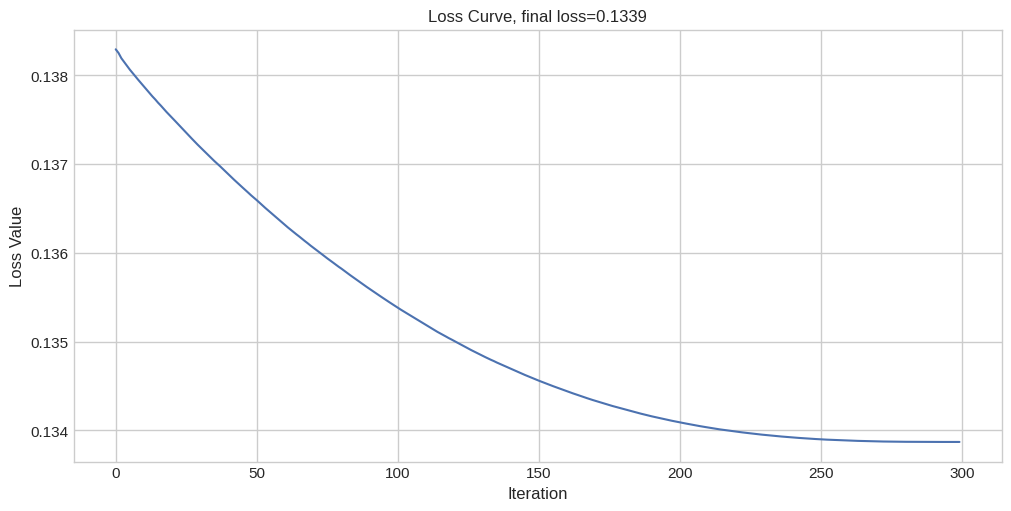

In [24]:
# second stage optimization
torch.cuda.empty_cache()

lr_base=1e-5
lr_end=0
niter=300

qvec_ = qvec.detach().clone().requires_grad_(True)
tvec_ = tvec.detach().clone().requires_grad_(True)
log_sizes_ = log_sizes.detach().clone().requires_grad_(True)    
pps_ = pps.detach().clone().requires_grad_(True)
log_focals_ = log_focals.detach().clone().requires_grad_(True)
median_depth_ = torch.median(depth_map_tensor.reshape(len(images), -1), dim=-1)[0].detach()
core_depth_ = depth_map_tensor / median_depth_[:, None, None, None]

loss_pix = gamma_loss(0.5)

params = [{
    "params": [
        qvec_.requires_grad_(True), 
        tvec_.requires_grad_(True), 
        log_sizes_.requires_grad_(True),
        pps_.requires_grad_(True),
        log_focals_.requires_grad_(True),
        core_depth_.requires_grad_(True)
    ],
    "name": ["qvec", "tvec", "log_sizes", "pps", "log_focals", "core_depth"]
}]

optimizer = torch.optim.Adam(params, lr=1, weight_decay=0, betas=(0.9, 0.9))

loss_list = []
for iter in tqdm(range(niter or 1)):
    K, (w2cam, cam2w) = make_K_cam_depth(log_focals_, pps_, tvec_, qvec_, min_focals, max_focals, imsizes)
    
    
    alpha = (iter / niter)
    lr = cosine_schedule(alpha, lr_base, lr_end)
    adjust_learning_rate_by_lr(optimizer, lr)
    optimizer.zero_grad()

    Ks_i = K[indexes_i]
    Ks_j = K[indexes_j]
    w2cam_i = w2cam[indexes_i]
    w2cam_j = w2cam[indexes_j]
    cam2w_i = cam2w[indexes_i]
    cam2w_j = cam2w[indexes_j]

    loss = 0.0

    # security! optimization is always trying to crush the scale down
    depths_i_list, depths_j_list = [], []
    depth_map_tensor_ = core_depth_ * median_depth_[:, None, None, None]
    for start_idx in range(0, len(corr_points_i_normalized), depth_batch_size):
        end_idx = min(start_idx + depth_batch_size, len(corr_points_i_normalized))
        depths_i_list.append(F.grid_sample(
            depth_map_tensor_[indexes_i_arr[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_i_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2))

        depths_j_list.append(F.grid_sample(
            depth_map_tensor_[indexes_j_arr[start_idx:end_idx]].permute(0, 3, 1, 2),
            corr_points_j_normalized[start_idx:end_idx, None],
            align_corners=True,
            mode='bilinear'
        ).squeeze(1, 2))
    
    depths_i = torch.cat(depths_i_list, dim=0).reshape(-1)
    depths_j = torch.cat(depths_j_list, dim=0).reshape(-1)

    sizes = log_sizes_.exp()
    global_scaling = 1 / sizes.min()
    depths_i_scaled = depths_i * global_scaling * sizes[indexes_i]
    depths_j_scaled = depths_j * global_scaling * sizes[indexes_j]
    
    cam_coords_i = torch.stack([
        (corr_points_i[:, 0] - Ks_i[:, 0, 2]) / Ks_i[:, 0, 0],
        (corr_points_i[:, 1] - Ks_i[:, 1, 2]) / Ks_i[:, 1, 1],
        depths_i_scaled.squeeze()
    ], dim=-1)
    cam_coords_j = torch.stack([
        (corr_points_j[:, 0] - Ks_j[:, 0, 2]) / Ks_j[:, 0, 0],
        (corr_points_j[:, 1] - Ks_j[:, 1, 2]) / Ks_j[:, 1, 1],
        depths_j_scaled.squeeze()
    ], dim=-1)
    world_coords_i = (cam2w_i[:, :3, :3] @ cam_coords_i[..., None]).squeeze() + cam2w_i[:, :3, 3]
    world_coords_j = (cam2w_j[:, :3, :3] @ cam_coords_j[..., None]).squeeze() + cam2w_j[:, :3, 3]

    # loss = ((world_coords_i - world_coords_j).abs() * corr_weight_valid[:, None]).mean()

    cam_coords_i2j = (w2cam_j[:, :3, :3] @ (world_coords_i - cam2w_j[:, :3, 3])[..., None]).squeeze()
    cam_coords_j2i = (w2cam_i[:, :3, :3] @ (world_coords_j - cam2w_i[:, :3, 3])[..., None]).squeeze()
    
    loss = (loss_pix(cam_coords_i2j[:, :2] / cam_coords_i2j[:, 2:] * cam_coords_j[:, 2:], cam_coords_j[:, :2]) * corr_weight_valid).mean() + \
           (loss_pix(cam_coords_j2i[:, :2] / cam_coords_j2i[:, 2:] * cam_coords_i[:, 2:], cam_coords_i[:, :2]) * corr_weight_valid).mean()

    P_i = Ks_i @ w2cam_i
    P_j = Ks_j @ w2cam_j
    Fm = kornia.geometry.epipolar.fundamental_from_projections(P_i[:, :3], P_j[:, :3])
    err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, None, :2], corr_points_j[:, None, :2], Fm, squared=False, eps=1e-08)
    # err = kornia.geometry.symmetrical_epipolar_distance(corr_points_i[:, :2], corr_points_j[:, :2], Fm, squared=False, eps=1e-08)
    loss = loss + (err * corr_weight_valid[:, None]).mean() * 0.05
    
    loss_list.append(loss.item())

    loss.backward()
    optimizer.step()

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.title(f'Loss Curve, final loss={loss_list[-1]:.4f}')
plt.show()

In [26]:
# pred w2c
pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(w2cam), 1, 1)
pred_se3[:, :3, :3] = torch.tensor(w2cam[:, :3, :3], device=device)
pred_se3[:, 3, :3] = torch.tensor(w2cam[:, :3, 3], device=device)

results = evaluate_auc(pred_se3, gt_se3, device)

/tmp/ipykernel_23838/418439452.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3[:, :3, :3] = torch.tensor(w2cam[:, :3, :3], device=device)
/tmp/ipykernel_23838/418439452.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_se3[:, 3, :3] = torch.tensor(w2cam[:, :3, 3], device=device)


    --  Umeyama Scale:  0.13070958269610713
    --  Umeyama Rotation: 
 [[ 0.45270223  0.64145311 -0.61935342]
 [-0.23975575  0.75659286  0.60834557]
 [ 0.85882351 -0.12690586  0.49630336]]
    --  Umeyama Translation: 
 [[ 0.03133841]
 [-0.298273  ]
 [ 0.46864729]]
    --  Pair Rot   Error (Deg) of Vanilla:       0.99
    --  Pair Trans Error (Deg) of Vanilla:       1.88
    --  AUC at 30: 0.9481
